In [1]:
# import
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, LocalCluster
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib import colors

from eofs.xarray import Eof
#from eofs.examples import example_data_path

In [2]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 31.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50148,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 31.92 GiB
Comm: tcp://127.0.0.1:50209,Total threads: 4
Dashboard: http://127.0.0.1:50210/status,Memory: 5.32 GiB
Nanny: tcp://127.0.0.1:50156,


In [3]:
# Make garbage collection explicit to prevent deadlocks - Adapted from:
# https://nbviewer.org/github/awslabs/amazon-asdi/blob/main/examples/dask/notebooks/era5_zarr.ipynb

import gc
from distributed import WorkerPlugin


class WorkerExplicitGC(WorkerPlugin):
    def setup(self, worker):
        self.worker = worker
        gc.disable()

    def transition(self, key, start, finish, *args, **kwargs):
        if finish == "executing":
            self.worker._throttled_gc.collect()
            if gc.isenabled():
                gc.disable()


plugin = WorkerExplicitGC()
client.register_worker_plugin(plugin)

{'tcp://127.0.0.1:50186': {'status': 'OK'},
 'tcp://127.0.0.1:50197': {'status': 'OK'},
 'tcp://127.0.0.1:50200': {'status': 'OK'},
 'tcp://127.0.0.1:50203': {'status': 'OK'},
 'tcp://127.0.0.1:50206': {'status': 'OK'},
 'tcp://127.0.0.1:50209': {'status': 'OK'}}

In [4]:
# construct filelist for yearly datasets
# define the urls
base_url = "https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/"
base_url_t = "/e5.moda.an.sfc.128_034_sstk.ll025sc."
base_url3 = ".nc"

base_url1 = "https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/"
base_url_p= "/e5.moda.fc.sfc.meanflux.235_055_mtpr.ll025sc."
base_url3 = ".nc"

# create datetimeindex
time_dim = pd.DatetimeIndex(
    [
        mon_day
        for y in range(1979, 2022)
        for mon_day in pd.date_range(f"{y}-01-01", f"{y}-12-01", freq="1MS")
    ]
)


file_list_t = []
file_list_p = []
for dt in time_dim[::12]:  # 3 months belong to the same year
    # get year and month
    year = dt.strftime("%Y")
    month = year + "010100"
    month1 = year + "120100"

    # build complete file name
    single_file_t = base_url + year + base_url_t + month + "_" + month1 + base_url3
    single_file_p = base_url1 + year + base_url_p + month + "_" + month1 + base_url3
    file_list_t.append(single_file_t)
    file_list_p.append(single_file_p)

print(len(file_list_t))
print(file_list_p[0])

43
https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/1979/e5.moda.fc.sfc.meanflux.235_055_mtpr.ll025sc.1979010100_1979120100.nc


In [5]:
time_dim = pd.DatetimeIndex(
    [
        mon_day
        for y in range(1979, 2022)
        for mon_day in pd.date_range(f"{y}-01-01", f"{y}-12-01", freq="1MS")
    ]
)

lsm = xr.open_dataset(
                      'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')

lsm = lsm['LSM'].sel(latitude=slice(65,-65),longitude=slice(120,300),time=lsm.time[0])
lsm = lsm.expand_dims(time=time_dim)
lsm.to_netcdf('data/lsm.nc')

OSError: [Errno -51] NetCDF: Unknown file format: b'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'

In [21]:
# Unit: K
ds_t = xr.open_mfdataset(file_list_t, parallel=True, chunks={"time": "50MB"})
ds_t = ds_t['SSTK'].sel(latitude=slice(65,-65),longitude=slice(120,300)).compute()
ds_t.to_netcdf('data/t_total.nc')
ds_t_mean = ds_t.mean(dim='time')
ds_t_mean.to_netcdf('data/t_mean.nc')
ds_t_anom = ds_t - ds_t_mean
ds_t_anom.to_netcdf('data/t_anomaly.nc')
ds_t_anom_sea = ds_t - ds_t_mean.where(lsm==0)
ds_t_anom_sea.to_netcdf('data/t_anomaly_sea.nc')

OSError: [Errno -51] NetCDF: Unknown file format: b'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/2020/e5.moda.an.sfc.128_034_sstk.ll025sc.2020010100_2020120100.nc'

In [22]:
# Unit: kg m**-2 s**-1 
ds_p = xr.open_mfdataset(file_list_p, parallel=True, chunks={"time": "50MB"})
ds_p = ds_p['MTPR'].sel(latitude=slice(65,-65),longitude=slice(120,300)).compute()
ds_p.to_netcdf('data/p_total.nc')
ds_p_mean = ds_p.mean(dim='time')
ds_p_mean.to_netcdf('data/p_mean.nc')
ds_p_anom = ds_p - ds_p_mean
ds_p_anom.to_netcdf('data/p_anomaly.nc')
ds_p_anom_sea = ds_p - ds_p_mean.where(lsm==0)
ds_p_anom.where(lsm==0).to_netcdf('data/p_anomaly_sea.nc')

OSError: [Errno -51] NetCDF: Unknown file format: b'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/1989/e5.moda.fc.sfc.meanflux.235_055_mtpr.ll025sc.1989010100_1989120100.nc'

In [2]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [3]:
t_anom_0 = xr.load_dataset('data/t_anomaly_sea.nc')['SSTK']

t_anom = detrend_dim(t_anom_0,'time')
climatology_mean = t_anom.groupby('time.month').mean('time')
climatology_std = t_anom.groupby('time.month').std('time')
t_anom_std = xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  t_anom.groupby('time.month'),
                                  climatology_mean, climatology_std)

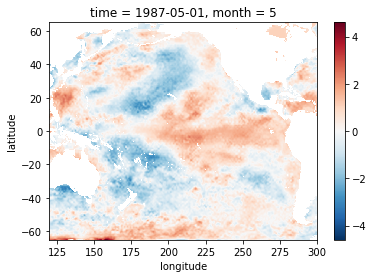

In [4]:
t_anom_std.sel(time=t_anom_std.time[100]).plot()

In [5]:
p_anom_0 = xr.load_dataset('data/p_anomaly_sea.nc')['MTPR']

p_anom = detrend_dim(p_anom_0,'time')
climatology_mean = p_anom.groupby('time.month').mean('time')
climatology_std = p_anom.groupby('time.month').std('time')
p_anom_std = xr.apply_ufunc(
                                  lambda x, m, s: (x - m) / s,
                                  p_anom.groupby('time.month'),
                                  climatology_mean, climatology_std)

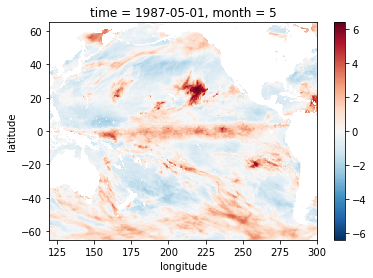

In [6]:
p_anom_std.sel(time=p_anom_std.time[100]).plot()

In [7]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(t_anom_std.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(t_anom_std, weights=wgts)

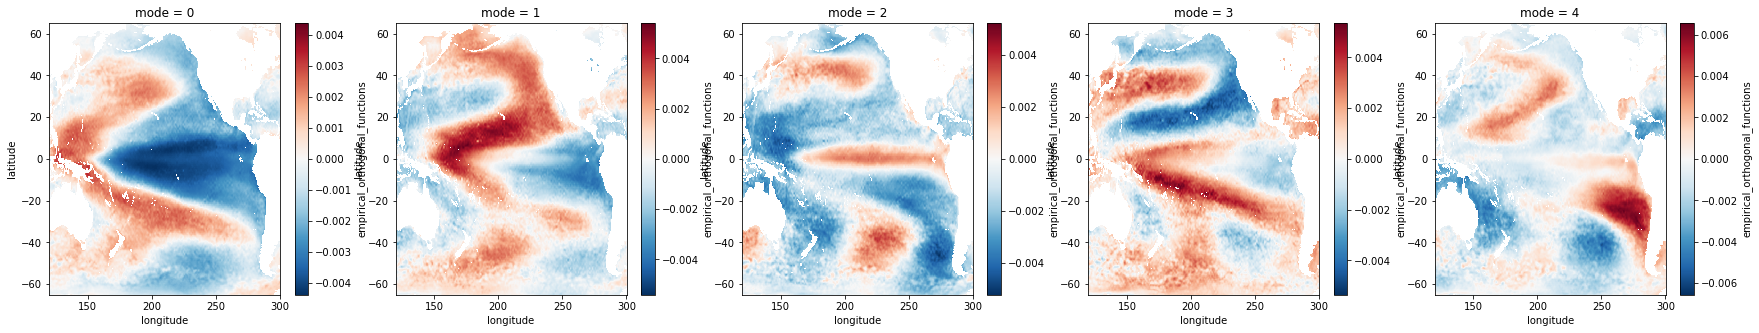

In [8]:
neofs = 5
eofs = solver.eofs(neofs=neofs)

fig,axes = plt.subplots(1,neofs,figsize=(neofs*6,5))
for i_eof in range(neofs):
    eofn = eofs.sel(mode=i_eof)
    eofn.plot(ax=axes[i_eof])
plt.show()

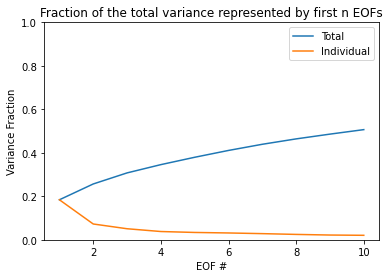

In [12]:
varfrac = solver.varianceFraction()
neofs = 10
varfracn = varfrac[:neofs]
#print(varfrac10)
plt.figure()
plt.title('Fraction of the total variance represented by first n EOFs')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.plot(np.arange(neofs)+1,[np.sum(varfracn[:i+1]) for i in range(neofs)],label='Total')
plt.plot(np.arange(neofs)+1,varfracn,label='Individual')
plt.ylim(0,1)
plt.legend()
plt.show()

In [17]:
neofs=5
reconstructed_SST = solver.reconstructedField(neofs)
corr = xr.corr(reconstructed_SST,t_anom_0,dim=('time'))
corr.plot()

In [21]:
p_anom_0 = xr.load_dataset('data/p_anomaly.nc')['MTPR']
corr_p = xr.corr(solver.reconstructedField(1),p_anom_0,dim=('time'))
corr_p.plot()